Snippets:
* `(pyvenv)> python3 -m pip freeze > reqs.txt` - wyeksportuj bib pyvenv'a
* `(pyvenv)> python3 -m pip install -r reqs.txt` - zaktualizuj biblioteki pyvenv'a

Utils

In [1]:
## CODE
import datetime

ceil = lambda x: int(x + (x!=int(x)))
timestamp = lambda: datetime.datetime.now().strftime("%Y%m%dT%H%M%S")

=== DATA READ ===

LOAD `((c x *.jpg; c x *.csv[label_x_ref,*labels_cls]) -> (dx, dy, dl))`

> Wczytaj i zwaliduj dane wejściowe (walidacje w komentarzach w funkcji)

params:
* `data_x_target_shape: (image_res_X, image_res_Y, Channels)`   - standaryzacja obrazów
* `label_x_ref`           - kolumna w pandas'ie z hashami do obrazów
* `labels_cls`            - kolumny w pandas'ie z kategoriami klasyfikacji

args:
* `data_x_path_regex`     - regex do plików z input'em (obrazów)
* `data_y_path_regex`     - regex do csv-ek z output'em (ground of truth), load merguje je ze sobą

output:
* ~~`dx: {dy[label_x_ref]: ndarray[c, *data_x_target_shape]]}` - słownik z obrazami hashowany `label_x_ref`~~ (do użytku wewn.; tylko dla walidacji poprawności)
* `dy: pandas.dataframe[label_x_ref,*labels_cls, ...]` - ... (wszystko do uczenia powinno tu być, kategorie w każdej formie)
* ~~`dl: Tuple[string]` -  lista kategorii po filtracji~~

In [3]:
## PARAMS
data_x_target_shape = (600, 450, 3)
label_x_ref = 'image'
# labels_cls = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']  # klasyfikacja kategoryczna pełna
labels_cls = ['MEL', 'NV']  # klasyfikacja (de-facto) binarna

In [4]:
## CODE
import glob
import cv2
import pandas as pd
import numpy as np

label_x_path    = 'path'
label_y_sparse  = 'sparse'
label_y_cat     = 'categorical'

## preprocess X data
data_x_target_res = data_x_target_shape[:2]

def data_x_loader(data_x_path):
    x = data_x_path
    x = cv2.imread(x)
    x = cv2.resize(x, data_x_target_res)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2YCrCb)
    return x

def load(data_x_path_regex, data_y_path_regex):
    # read & merge Y data
    data_y_paths = glob.glob(data_y_path_regex)
    print("CSV found:")
    for data_y_path in data_y_paths:
        print(f"    {data_y_path}") 

    assert data_y_paths.__len__() > 0
    dy_full = pd.concat([pd.read_csv(data_y_path) for data_y_path in data_y_paths])

    # todo: filter out nulls
    dy = dy_full

    # filter out samples & labels of fewer than 2 positive
    labels_cls_too_few = dy[labels_cls].loc[:, (dy[labels_cls].sum() < 2)].columns
    for label_cls_too_few in labels_cls_too_few:
        dy = dy.drop(dy[dy.loc[:, label_cls_too_few] == 1].index, axis=0)
    dy = dy.drop(labels_cls_too_few, axis=1)
    dl = [label_cls for label_cls in labels_cls if label_cls not in labels_cls_too_few]

    # read & filter_out by Y & map X data
    data_x_paths = glob.glob(data_x_path_regex)
    data_x_paths = [dxp.replace('\\', '/') for dxp in data_x_paths]
    map_ref2path_full = {ref: next((dxp for dxp in data_x_paths if ref in dxp), None) for ref in dy_full[label_x_ref]}
    map_ref2path = {ref: data_x_path for ref, data_x_path in map_ref2path_full.items() if (ref == dy[label_x_ref]).any() and data_x_path is not None}
    # dx = {ref: data_x_loader(data_x_path) for ref, data_x_path in map_ref2path.items()}

    # filter out Y entries that dont have X entry
    dy = dy.loc[dy[label_x_ref].isin(map_ref2path.keys())]

    # add path column
    paths = [map_ref2path[ref] for ref in dy[label_x_ref]]
    dy[label_x_path] = paths

    # add sparse & categorical classification column
    dy[label_y_sparse] = dy[dl].to_numpy().argmax(axis=1)
    dy[label_y_cat] = [dl[y_spar] for y_spar in dy[label_y_sparse]]

    print(
    f"""Read stats:
    # entries ok: {dy.__len__()}
    # excess X: {map_ref2path_full.__len__() - map_ref2path.__len__()}
    # excess Y: {dy_full.__len__() - dy.__len__()}
    # excess L: {labels_cls_too_few.__len__()}  """) # e.L- Labels of too little samples

    print("# samples/label:")
    print(dy[dl].sum(axis=0).astype(int), end="\t\n")
    return None, dy, dl

In [5]:
## PLAYGROUND
# użyte dane wejściowe: https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
data_x_path_regex = r"../ISIC2018_Task3_Training_Input/*.jpg"
data_y_path_regex = r"../ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"

_, dy, _ = load(data_x_path_regex, data_y_path_regex)
dl = labels_cls
dy = dy[np.any([dy[label] == 1 for label in dl], axis=0)]
dy

CSV found:
    ../ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
Read stats:
    # entries ok: 10015
    # excess X: 0
    # excess Y: 0
    # excess L: 0  
# samples/label:
MEL    1113
NV     6705
dtype: int32	


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,path,sparse,categorical
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0024306.jpg,1,NV
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0024307.jpg,1,NV
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0024308.jpg,1,NV
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0024309.jpg,1,NV
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0024310.jpg,0,MEL
...,...,...,...,...,...,...,...,...,...,...,...
10008,ISIC_0034314,0.0,1.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0034314.jpg,1,NV
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0034316.jpg,0,MEL
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0034317.jpg,0,MEL
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0034319.jpg,1,NV


In [6]:
## PLAYGROUND > CHECK IF TF ON GPU
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

from keras import backend
print(backend._get_available_gpus())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
['/device:GPU:0']


In [7]:
## PLAYGROUND > CHECK IF CUPY ON GPU
import cupy as cp

cp.zeros((1,)).device

<CUDA Device 0>

=== PREPROCESING ===


params:
* `batch_size: int` - wspólne dla wszystkich generatorów i klasyfikatorów
* `tts_factor: float in (0, 1)` - train-test split factor
* `train_datagen: keras.preprocessing.image.ImageDataGenerator` - ustawienia augmentacji danych

input:
* `dy: pandas.dataframe[label_x_ref,*labels_cls, ...]`

output:
* `train_generator: keras.preprocessing.image.DataFrameIterator`
* `test_generator:  keras.preprocessing.image.DataFrameIterator`
* ...


In [8]:
## CODE
def label_stratifier(dyi, spc):
    """ duplicate samples in dataframe until desired # (=spc) of each category reached"""
    dyo = pd.concat([dupl[:(spc-(dx*ldupl))] 
        for cat in dl  
        for dupl, ldupl in ((dyi[dyi[cat] == 1.0], len(dyi[dyi[cat] == 1.0])),)
        for dx in range(ceil(spc/ldupl))
    ])
    dyo = dyo.sample(frac=1)  # shuffle

    dy_info = pd.concat([
        dyi[dl].sum(axis=0).astype(int).rename("was"), 
        dyo[dl].sum(axis=0).astype(int).rename("is")], axis=1)
    return dyo, dy_info 


In [9]:
## PARAMS
from keras.preprocessing import image

batch_size = 16
tts_factor = .1
train_datagen = image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
)

In [10]:
## PLAYGROUND
from sklearn.model_selection import train_test_split

dyt1, dys1 = train_test_split(dy, test_size=tts_factor, stratify=dy[dl].to_numpy().argmax(axis=1), shuffle=True, )

dyt, dyt_info = label_stratifier(dyt1, 12000)
print("Training dataset: \n", dyt_info)

dys = dys1
print("Training dataset: \n", dys[dl].sum(axis=0).astype(int))

train_datagen = train_datagen
train_generator = train_datagen.flow_from_dataframe(
      dataframe=dyt,
      directory=".",
      x_col=label_x_path,
      y_col=dl,
      # subset="training",
      batch_size=batch_size,
      # seed=42,
      shuffle=True,
      class_mode="raw",
      target_size=data_x_target_res,
)

whole_train_generator = train_datagen.flow_from_dataframe(
      dataframe=dy,
      directory=".",
      x_col=label_x_path,
      y_col=dl,
      # subset="training",
      batch_size=batch_size,
      # seed=42,
      shuffle=True,
      class_mode="raw",
      target_size=data_x_target_res,
)

smol_generator = train_datagen.flow_from_dataframe(  # for end-of-samples testing 
      dataframe=dyt[:int(batch_size*1.5)],
      directory=".",
      x_col=label_x_path,
      y_col=dl,
      # subset="training",
      batch_size=batch_size,
      # seed=42,
      shuffle=True,
      class_mode="raw",
      target_size=data_x_target_res,
)

val_generator = None  # za mało sampli

test_datagen = image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
      dataframe=dys,
      directory=".",
      x_col=label_x_path,
      y_col=dl,
      # subset="validation",
      batch_size=batch_size,
      # seed=42,
      shuffle=False,
      class_mode="raw",
      target_size=data_x_target_res,
)

dummy_test_datagen = test_datagen
dummy_test_generator = dummy_test_datagen.flow_from_dataframe(  # dane treningowe bez powtarzania, augmentacji i shuffle, do testów
      dataframe=dyt1,
      directory=".",
      x_col=label_x_path,
      y_col=dl,
      # subset="validation",
      batch_size=batch_size,
      # seed=42,
      shuffle=False,
      class_mode="raw",
      target_size=data_x_target_res,
) 
# bez shuffle bo nie da się (chyba) inaczej odtworzyć która próbka jest która z samego generatora (zob. gen2ojala -> filenames)


Training dataset: 
       was     is
MEL  1002  12000
NV   6034  12000
Training dataset: 
 MEL    111
NV     671
dtype: int32
Found 24000 validated image filenames.
Found 7818 validated image filenames.
Found 24 validated image filenames.
Found 782 validated image filenames.
Found 7036 validated image filenames.


=== METRCS ===

SUMUP

> Wygeneruj podsumowanie klasyfikacji testowej

params:
* \-

args:
* `y_got, y_pred: np.ndarray[Samples, Labels] || np.ndarray[Samples] || List[Label_str]` - klasyfikacje odpowiednio: ground-of-truth, przewidywane 
* `references: Optional[List[Any]]` - dane do identyfikacji próbek, za porządkiem `y_got`, `y_pred`
* `labels: Optional[List]` - wektor kategorii

output:
* `juxta: pd.DataFrame[reference, ...]` - lista porównań wyniku klasyfikacji w odniesieniu do referencji
* `confusion_mx_sample: NestedLists[Labels Labels]` - macierz pomyłek względem liczby sampli w porządku `[y_got, y_pred]`
* `confusion_mx_percent: NestedLists[Labels Labels]` - macierz pomyłek względem % sampli danych `y_got`
* `references_mx: NestedLists[Labels, Labels, X* str]]` - macierz listy referencji do próbek w danej komórce macierzy pomyłek
* `labels: List[str || int]` - wektor kategorii (generyczny jeśli nie podano w args)


In [11]:
## CODE
from sklearn.metrics import confusion_matrix

juxta_col_reference = "reference"
juxta_col_cat = ["GoT", "predicted"]
juxta_col_sparse = ["#GoT", "#predicted"]

def sumup(y_got, y_pred, references=None, labels=None):
    ## convert y_got, y_pred to sparse
    if type(y_got[0]) == str:  # categorical
        dl = labels or list(set(y_got).union(list(y_pred)))
        y_got = np.asarray([dl.index(y_s) for y_s in y_got])
        y_pred = np.asarray([dl.index(y_s) for y_s in y_pred])
    elif np.asarray(y_got).shape.__len__() == 1:  # sparse
        dl = labels or list(set(y_got).union(list(y_pred)))
    elif np.asarray(y_got).shape.__len__() == 2:  # full
        dl = labels or np.arange(y_got[0].__len__())
        y_got = y_got.argmax(axis=1)
        y_pred = y_pred.argmax(axis=1)
    references = references or ["?"] *y_got.__len__()

    juxta = pd.DataFrame(zip(
            references, 
            [dl[catix] for catix in y_got], 
            [dl[catix] for catix in y_pred],
            y_got,
            y_pred,
        ), columns=[juxta_col_reference, *juxta_col_cat, *juxta_col_sparse])

    confusion_mx_sample  = confusion_matrix(y_got, y_pred, sample_weight=None).astype(int)
    
    # weights by y_got
    sample_weight = [(1/(y_got == catix).sum()) for catix in range(dl.__len__())]
    sample_weight = np.asarray([sample_weight[catix] for catix in y_got]) *100
    confusion_mx_percent = confusion_matrix(y_got, y_pred, sample_weight=sample_weight).astype(int)

    references_mx = [[juxta.loc[np.logical_and(
            juxta[juxta_col_sparse[0]] == catix_got,
            juxta[juxta_col_sparse[1]] == catix_pred
        ), juxta_col_reference].tolist() 
        for catix_pred in range(dl.__len__())] for catix_got in range(dl.__len__())]
    
    return juxta, confusion_mx_sample, confusion_mx_percent, references_mx, labels


=== DTC OJALA ===

GEN2OJALA
> Przetwórz dane generatora na wektor parametrów LBP_ui2 + VAR (Ojala et.al., 2002)

params:
* \-

args:
* `generator_raw: keras.preprocessing.image.DataFrameIterator -> np.ndarray[Batch_size, image_res_Y, image_res_X, Channels]` - generator danych
* `rbp_l: [N_rpb* (Radius_i: int, Points_i: int, Bins_i: int)]` - parametry: `radius` - promień sąsiedztwa LBP, `Points` - liczba pnktów sąsiedztwa LBP, `Bins` - liczba elementów histogramu LBP/VAR
* `no_batches: int = None` - liczba batch'ów do wygenerowania

output:
* `ojala_x: np.ndarray[Samples, Channel* (N_rbp* (2**Points_i+Bins_i))]` - macierz zlinearyzowanych wektorów parametrów
* `ojala_y: np.ndarray[Samples, Labels]` - macierz kategorii klasyfikacji
* `filepaths: Optional[None, List[str]]` - jeśli `generator_raw.shuffle == True`: lista nazw plików `dy["path"]` za porządkiem `ojala_x`, `ojala_y` 

In [31]:
## CODE
from tqdm import tqdm
import numpy as np
import cupy as cp

def quick_hist(*args, **kwargs):
    hi = cp.histogram(*args, **kwargs)[0] 
    return hi / hi.sum(axis=-1)

def rpb2lbp_consts(image_res, rbp):
    np = cp
    r, p, b = rbp

    adj_domain = np.linspace(0, 2*np.pi, p, endpoint=False)
    adj_weights = np.power(2, np.arange(p))

    vert_adj = ((r+1-1e-6)* np.sin(adj_domain)).astype(int)
    hori_adj = ((r+1-1e-6)* np.cos(adj_domain)).astype(int)

    vert_centres, hori_centres, _ = np.mgrid[r:image_res[0]-r, r:image_res[1]-r, 0:1]
    vert_cadj = vert_centres + vert_adj
    hori_cadj = hori_centres + hori_adj

    ld = ud = np.arange(2**p, dtype=np.uint32)
    ud_circled = ud + np.bitwise_and(ud, 1)*(2**p)
    ud_binary = np.bitwise_xor(ud_circled, ud_circled >>1)

    ud_merged = np.zeros(2**p, dtype=np.uint8)
    ld_merged = np.zeros(2**p, dtype=np.uint8)
    step = int((2**p)/p)

    for sx in range(0, 2**p, step): 
        # lookup condition
        ud_expo = (np.bitwise_and(ud_binary[sx:sx+step, None], (2**np.arange(p))))
        ud_sumup = (ud_expo != 0).astype(np.uint32)
        ud_sumup = ud_sumup[..., None].sum(axis=-2).squeeze()
        ud_merged[sx:sx+step] = ud_sumup

        # lookup value
        ld_expo = (np.bitwise_and(ld[sx:sx+step, None], (2**np.arange(p))))
        ld_sumup = (ld_expo != 0).astype(np.uint32)  
        ld_sumup = ld_sumup[..., None].sum(axis=-2).squeeze()
        ld_merged[sx:sx+step] = ld_sumup

    lookup = np.where(ud_merged <= 2, ld_merged, p+1)  # Ojala, 2002, (9, 10)

    return (vert_centres, hori_centres, vert_cadj, hori_cadj, 
            adj_weights, lookup,
            p, b)

def lbp_var(image_batch, lbp_consts):
    vert_centres, hori_centres, vert_cadj, hori_cadj, adj_weights, lookup, p, b = lbp_consts

    mx_cadj = image_batch[..., vert_cadj, hori_cadj]
    mx_centres = image_batch[..., vert_centres, hori_centres]

    lbp_idx_raster_l = ((mx_cadj <= mx_centres) * adj_weights)
    lbp_idx_raster_wa = lbp_idx_raster_l[..., None].sum(-2).squeeze()  # (w)ork(a)round for cupy bug
    lbp_idx_lin = lbp_idx_raster_wa.reshape((*image_batch.shape[:-2], -1))
    lbp_lin = lookup[lbp_idx_lin]
    hi_lbp = cp.apply_along_axis(quick_hist, -1, lbp_lin, bins=(p+2), range=(0, p+2))

    var_raster_l = cp.power(mx_cadj - mx_cadj[..., None].mean(axis=-2), 2)
    var_raster_wa = var_raster_l[..., None].sum(-2).squeeze()  # Ojala, 2002, (11)
    var_log_lin = cp.log1p(var_raster_wa.reshape((*image_batch.shape[:-2], -1)))
    hi_var = cp.apply_along_axis(quick_hist, -1, var_log_lin, b, range=None)

    return hi_lbp, hi_var

def gen2ojala(generator_raw, rpb_l, no_batches=None):
    no_batches = min(no_batches, generator_raw.__len__()) if no_batches else generator_raw.__len__()
    test_batch_x = generator_raw[0][0]
    batch_size = test_batch_x.__len__()
    data_x_target_res = test_batch_x.shape[-3:-1]
    no_samples = batch_size*(no_batches-1) + generator_raw[no_batches-1][0].__len__()
    no_params = 3*np.sum([(p+2)+b for _, p, b in rpb_l])

    ojala_x = np.zeros((no_samples, no_params), dtype=np.float64) # dtype default for np division
    ojala_y = np.zeros((no_samples, labels_cls.__len__()), dtype=np.float64)

    lbp_consts_l = [rpb2lbp_consts(data_x_target_res, rpb) for rpb in rpb_l]

    for batch_ix in tqdm(range(no_batches)):
        batch_x, batch_y = generator_raw[batch_ix]
        ojala_y[batch_ix*batch_size:(batch_ix+1)*batch_size] = batch_y

        oxb = []
        batch_x = cp.asarray(batch_x)
        # batch_x = cp.asarray([cv2.cvtColor(im, cv2.COLOR_RGB2HSV_FULL) for im in batch_x])
        batch_x = cp.moveaxis(batch_x, 3, 1)  # (Sample_ix, Channel, Y, X)
        for lc in lbp_consts_l:
            lbp_res, var_res = lbp_var(batch_x, lc)
            oxb.append(cp.asnumpy(lbp_res))  # (RBP_conf, S, C, H)
            oxb.append(cp.asnumpy(var_res))  # (RBP_conf, S, C, H)
        
        lbp_merged = oxb
        lbp_merged = np.concatenate(lbp_merged, axis=-1) # concat lbp + var and reduce RBP_conf dim
        lbp_merged = lbp_merged.reshape((*batch_x.shape[:-3], -1)) # reduce Channel dim 
        ojala_x[batch_ix*batch_size:(batch_ix+1)*batch_size, :] = lbp_merged  # (S, C*R*H)

    filenames = None if generator_raw.shuffle else generator_raw.filenames[:(no_batches*batch_size)]

    return ojala_x, ojala_y, filenames


In [32]:
## PLAYGROUND > GENERATE TRAIN DATA

# [(radius, n_points, var_bins)] list
rpb_l= ((1, 8, 10), (2, 16, 18), (3, 16, 26))

ojala_tx, ojala_ty, _ = gen2ojala(train_generator, rpb_l, no_batches=None)


In [33]:
## PLAYGROUND > READ/WRITE TRAIN DATA
import pickle

# with open("ojala_tx_7x4000.pkl", 'wb') as f:
#     pickle.dump(ojala_tx, f)
# with open("ojala_ty_7x4000.pkl", 'wb') as f:
#     pickle.dump(ojala_ty, f)

# with open("ojala_tx_2x12000.pkl", 'wb') as f:
#     pickle.dump(ojala_tx, f)
# with open("ojala_ty_2x12000.pkl", 'wb') as f:
#     pickle.dump(ojala_ty, f)


# with open('ojala_tx_7x4000.pkl', 'rb') as f:
#     ojala_tx = pickle.load(f)
# with open('ojala_ty_7x4000.pkl', 'rb') as f:
#     ojala_ty = pickle.load(f)

# with open('ojala_tx_2x12000.pkl', 'rb') as f:
#     ojala_tx = pickle.load(f)
# with open('ojala_ty_2x12000.pkl', 'rb') as f:
#     ojala_ty = pickle.load(f)

In [34]:
## PLAYGROUND > GENERATE, READ/WRITE TRAIN DATA

ojala_sx,  ojala_sy,  filenames_s  = gen2ojala(test_generator, rpb_l, None)
ojala_dsx, ojala_dsy, filenames_ds = gen2ojala(dummy_test_generator, rpb_l, 100)

# with open("ojala_sb_2x12k.pkl", 'wb') as f:
#     pickle.dump((ojala_sx,  ojala_sy,  filenames_s, ojala_dsx, ojala_dsy, filenames_ds), f)

# with open('ojala_sb_2x12k.pkl', 'rb') as f:
#     (ojala_sx,  ojala_sy,  filenames_s, ojala_dsx, ojala_dsy, filenames_ds) = pickle.load(f)

100%|██████████| 30/30 [03:21<00:00,  6.70s/it]


2400 0.765


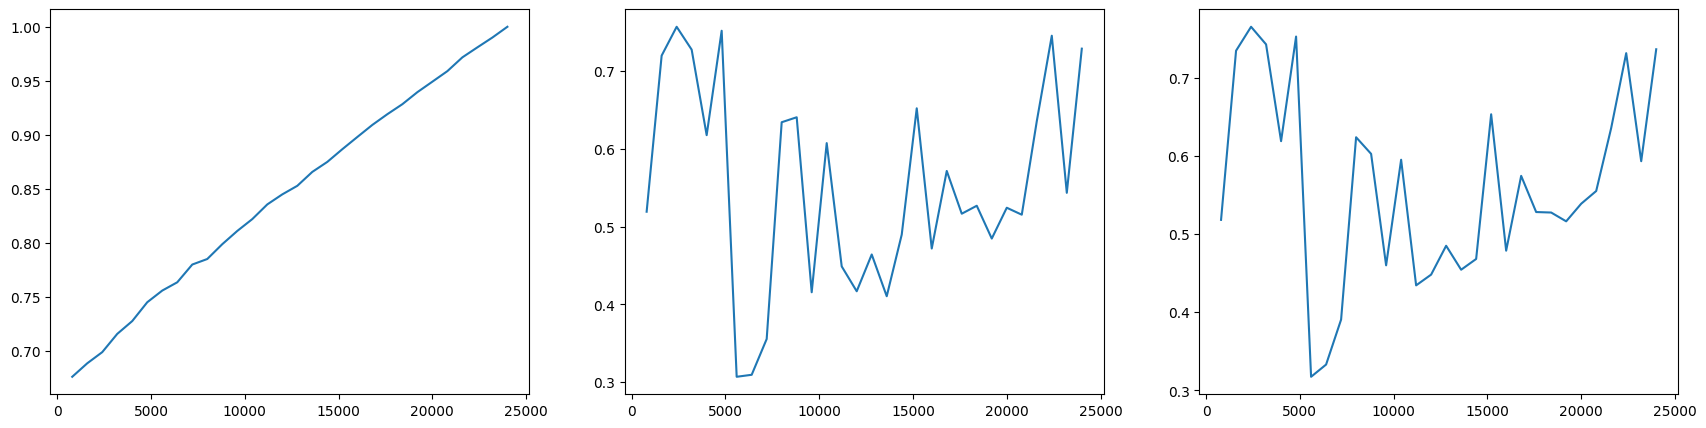

In [64]:
## PLAYGROUND > LEARN & EVAL BY NO OF SAMPLES; CHOOSE THE BEST
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier

tx = ojala_tx
ty = ojala_ty
sxl = [ojala_tx, ojala_sx, ojala_dsx]
syl = [ojala_ty, ojala_sy, ojala_dsy]
sl_idni = 2  # index by which dtc should be evaluated

best_acc = -1
best_ns = -1
acc_n = np.linspace(0, tx.__len__(), 31, endpoint=True, dtype=int)[1:]
acc_yl= [[] for _ in range(sxl.__len__())]

for ns in tqdm(acc_n):
    dtc_nev = DecisionTreeClassifier(splitter="best", criterion="gini")
    dtc_nev.fit(tx[:ns], ty[:ns])

    for six, (sx, sy) in enumerate(zip(sxl, syl)):
        py = dtc_nev.predict(sx)
        acc = np.all(sy==py, axis=1).sum() / sy.__len__()
        acc_yl[six].append(acc)

        if six==sl_idni and acc > best_acc:
            best_ns = ns
            best_acc = acc
            dtc_ojala_ = dtc_nev

fig, ax = plt.subplots(1, syl.__len__(), figsize=(7*sxl.__len__(), 5))
for aix, acc_y in enumerate(acc_yl):
    ax[aix].plot(acc_n, acc_y)
print(best_ns, best_acc)
    

In [63]:
## PLAYGROUND > EVALUATE MODEL
dtc_ojala = dtc_ojala_
# dtc_ojala = dtc_nev

ojala_lsx = ojala_sx
ojala_lsy = ojala_sy

ojala_py = dtc_ojala.predict(ojala_lsx)
juxta, confusion_mx_sample, confusion_mx_percent, references_mx, labels = sumup(ojala_lsy, ojala_py, references=filenames_ds, labels=dl)

print(confusion_mx_sample)
print(confusion_mx_percent)

for si in range(dl.__len__()):
    for pi in range(dl.__len__()):
        print(si, pi, references_mx[si][pi])


[[  8 103]
 [ 33 638]]
[[ 7 92]
 [ 4 95]]


=== CNN ===


params:
* ~~`batch_size`~~ - musi się zgrać z datagen
* `model....`
* `model.fit(...)`
* `flatten_res_max` - do jakiego rozmiaru `H*W` konwolucja ma zredukować obraz (żeby nie ograniczyć ilość parametrów warstw `Dense`)

args:
* `(train_generator, `~~`validation_generator`~~`)` - zostawiamy crossvalidation

output:
* `model: ...` 
* `history: keras.callbacks.History`

In [ ]:
## PLAYGROUND > CREATE MODEL
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# batch_size = 16
flatten_res_max = 200  

model = models.Sequential()
model.add(layers.Rescaling(1./255, 0., input_shape=data_x_target_shape))

conv_converg  = lambda cr: (((cr[0]-2) // 2), (cr[1]-2)//2)
step_channels = 1
conv_redo = data_x_target_res
while (conv_redo := conv_converg(conv_redo)) and conv_redo[0]*conv_redo[1] > flatten_res_max:
    step_channels += 1

for n_channels in np.linspace(16, 64, step_channels, endpoint=True):
    model.add(layers.Conv2D(n_channels, (3,)*2, activation='relu'))
    model.add(layers.MaxPooling2D((2,)*2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(dl), activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 600, 450, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 598, 448, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 299, 224, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 297, 222, 28)      4060      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 148, 111, 28)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 146, 109, 40)      1

In [ ]:
## PLAYGROUND > TRAIN
history = model.fit(
    train_generator,
    epochs=50,
)

Epoch 1/50
500/500 [==============================] - 598s 1s/step - loss: 0.4488 - accuracy: 0.7745
Epoch 2/50
500/500 [==============================] - 600s 1s/step - loss: 0.4390 - accuracy: 0.7790
Epoch 3/50
500/500 [==============================] - 627s 1s/step - loss: 0.4439 - accuracy: 0.7826
Epoch 4/50
175/500 [=========>....................] - ETA: 5:58 - loss: 0.4329 - accuracy: 0.7796

KeyboardInterrupt: 

In [ ]:
## PLAYGROUND > READ/WRITE MODEL, TRAINNING HISTORY

from tensorflow.keras.models import load_model
import pickle

model.save("cnn_2x4000.tf_pkl")
# model.save("cnn_7x1200.tf_pkl")

with open("cnnh_2x4000.pkl", 'wb') as f:
# with open("cnnh_7x1200.pkl", 'wb') as f:
    pickle.dump(history.history, f)

cnn = load_model('cnn_2x4000.tf_pkl')
# cnn = load_model('cnn_7x1200.tf_pkl')

with open("cnnh_2x4000.pkl", 'rb') as f:
# with open("cnnh_7x1200.pkl", 'rb') as f:
    h = pickle.load(f)


INFO:tensorflow:Assets written to: cnn_2x4000.tf_pkl\assets


INFO:tensorflow:Assets written to: cnn_2x4000.tf_pkl\assets


In [22]:
s_batches = 100
s_generator= test_generator

s_batches = np.minimum(s_batches, s_generator.__len__())
cnn_sy = np.concatenate([s_generator[bx][1] for bx in range(s_batches)])
cnn_py = cnn.predict(s_generator, steps=s_batches)

filenames = None if s_generator.shuffle else s_generator.filenames[:(s_batches*batch_size)]

juxta, confusion_mx_sample, confusion_mx_percent, references_mx, labels = sumup(cnn_sy, cnn_py, references=filenames, labels=dl)

print(confusion_mx_sample)
print(confusion_mx_percent)

for si in range(dl.__len__()):
    for pi in range(dl.__len__()):
        print(si, pi, references_mx[si][pi])

63/63 [==============================] - 12s 184ms/step
[[239  92]
 [181 490]]
[[72 27]
 [26 73]]
0 0 ['../ISIC2018_Task3_Training_Input/ISIC_0033496.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0026335.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0034236.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0027795.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0026984.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0027774.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0028451.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0027189.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0032139.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0025752.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0027915.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0032348.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0031008.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0027588.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0027721.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0032437.jpg', '../ISIC2018_Task3_Training_Input/ISIC_0026092.jp

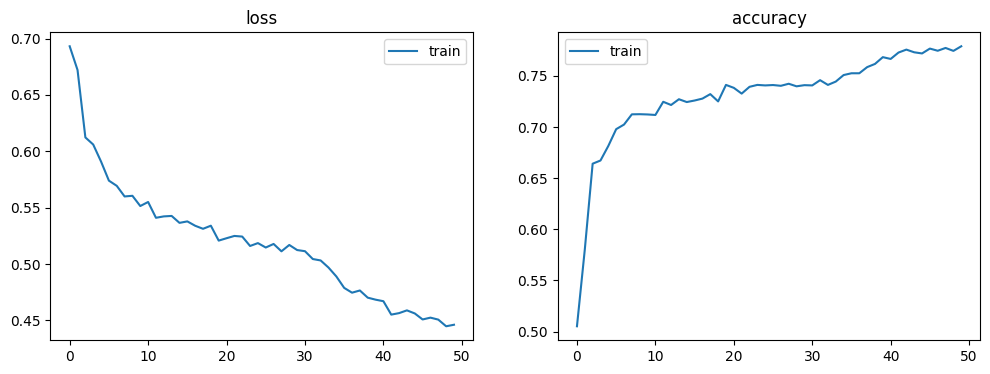

In [24]:
## PLAYGROUND > VISUALISE TRAINING HISTORY

from matplotlib import pyplot as plt

# Porównanie metryk uczenia
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title('loss')
ax[0].plot(h['loss'], label='train')
# ax[0].plot(h['val_loss'], label='val')
ax[0].legend()

ax[1].set_title('accuracy')
ax[1].plot(h['accuracy'], label='train')
# ax[1].plot(h['val_accuracy'], label='val')
ax[1].legend()